In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mohammadsanaee/prediction/main/df_daily.csv')

In [3]:
df.head()

,Unnamed: 0,date,price_pesos,exchange,price_usd,gas_price,coal_price,gas_rate,coal_rate,log_price
0,0,2006-06-26,3696.799565,53.4002,69.228197,7.1,2.100882,9.750450,32.951961,3.426412
1,1,2006-06-27,4494.720000,53.4750,84.052735,7.1,2.100882,11.838413,40.008299,NaN
2,2,2006-06-28,3419.524583,53.5800,63.820914,7.1,2.100882,8.988861,30.378146,3.471716
3,3,2006-06-29,2904.085417,53.5502,54.231084,7.1,2.100882,7.638181,25.813478,3.346610
4,4,2006-06-30,4178.192500,53.1102,78.670246,7.1,2.100882,11.080316,37.446286,3.480780


In [4]:
df1 = df.reset_index()['price_pesos']

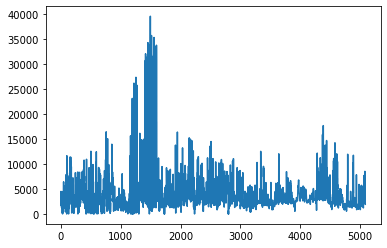

In [5]:
plt.plot(df1)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
df1

array([[0.09346681],
       [0.11364076],
       [0.08645642],
       ...,
       [0.05852367],
       [0.0581322 ],
       [0.04859631]])

In [8]:
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [9]:
from torch.utils.data import Dataset , DataLoader

class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data) 
test_dataset = StockDataset(test_data) 

In [10]:
batch_size = 64
train_dataloader = DataLoader(train_dataset,batch_size,drop_last=True)
test_dataloader = DataLoader(test_dataset,batch_size , drop_last=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
import torch.nn as nn
class Lstm_model(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers):
        super(Lstm_model, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))
        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def predict(self,x):
        hn,cn  = self.init()
        final_out = self.fc(out[-1])
        return final_out

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 3

model = Lstm_model(input_dim , hidden_size , num_layers).to(device)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train(dataloader):
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"train loss: {loss:>7f} ")
def test(dataloader):
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(100,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
       
        if batch == len(dataloader)-1:
            loss = loss.item()
            print(f"test loss: {loss:>7f} ")
epochs = 90000000
for epoch in range(epochs):
  if epoch %500000 == 0:
      print(f"epoch {epoch} ")
      train(train_dataloader)
      test(test_dataloader)

In [16]:
x

NameError: ignored

In [21]:
import math
from sklearn.metrics import mean_squared_error,r2_score
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(100,64,1)
            pred = model(x,hn,cn)[0]
            pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
        print(pred_arr[500],y_arr[500])
        print(f" r2_score = {r2_score(y_arr, pred_arr)}")
        return math.sqrt(mean_squared_error(y_arr,pred_arr))
    
# calculating final loss metrics
print(f"train mse loss {calculate_metrics(train_dataloader)}")
print(f"test mse loss {calculate_metrics(test_dataloader)}")

2318.0154 818.8821
 r2_score = 0.7757065667371797
train mse loss 1730.5463732590351
2345.771 1711.8489
 r2_score = 0.5564826985550313
test mse loss 1540.8048221627553
